### Import the necessary program libraries

In [1]:
import pandas as pd
import plotly.graph_objects as go
from classes import BaseLoader
import plotly.express as px
from funcs import to_float, get_color
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.colors as mcolors
from sqlalchemy import create_engine
from settings import mariadb_string, mariadb_config

### Select the data

In [23]:
sql_query = """select 
	*
from
	stock_price s
where
	s.symbol = '{}'
group BY
	s.`date`
order by
	s.`date` asc;"""

loader = BaseLoader(mariadb_config)
symbol = loader.choose_id()
df_stock = pd.read_sql(sql_query.format(symbol), create_engine(mariadb_string))
df_stock["date"] = pd.to_datetime(df_stock["date"])
df_stock.info()

Please choose the symbol from the index which data should be analysed.
symbol AMZN: Amazon
symbol BKNG: Booking Holdings
symbol DASH: DoorDash
symbol HD: Home Depot
symbol LOW: Lowe’s
symbol MCD: McDonald's
symbol NKE: Nike
symbol SBUX: Starbucks
symbol TJX: TJX Companies
symbol TSLA: Tesla
You can typ 'q' to quit.


symbol:  DASH


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  1155 non-null   object        
 1   date    1155 non-null   datetime64[ns]
 2   open    1155 non-null   float64       
 3   high    1155 non-null   float64       
 4   low     1155 non-null   float64       
 5   close   1155 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 54.3+ KB


### Check the data and make some cleaning

In [5]:
# Check the dates
df_stock.loc[df_stock["date"] > "2022-06-01"].head()

,symbol,date,open,high,low,close
5683,AMZN,2022-06-02,121.684,125.61,120.045,125.511
5684,AMZN,2022-06-03,124.200,124.40,121.046,122.350
5685,AMZN,2022-06-06,125.245,128.99,123.810,124.790
5686,AMZN,2022-06-07,122.005,124.10,120.630,123.000
5687,AMZN,2022-06-08,122.610,123.75,120.750,121.180


In [24]:
df_stock.head()

,symbol,date,open,high,low,close
0,DASH,2020-12-09,182.00,195.500,163.800,189.51
1,DASH,2020-12-10,179.71,187.695,172.636,186.00
2,DASH,2020-12-11,176.52,182.000,168.250,175.00
3,DASH,2020-12-14,169.10,170.000,151.200,160.00
4,DASH,2020-12-15,157.10,161.420,153.760,158.89


In [16]:
df_stock.tail()

,symbol,date,open,high,low,close
6461,BKNG,2025-07-11,5692.62,5725.390,5660.648,5717.10
6462,BKNG,2025-07-14,5697.36,5769.940,5689.025,5766.04
6463,BKNG,2025-07-15,5743.61,5790.000,5640.000,5675.53
6464,BKNG,2025-07-16,5652.96,5677.345,5625.215,5658.13
6465,BKNG,2025-07-17,5656.50,5718.420,5646.400,5683.94


### Check the chart

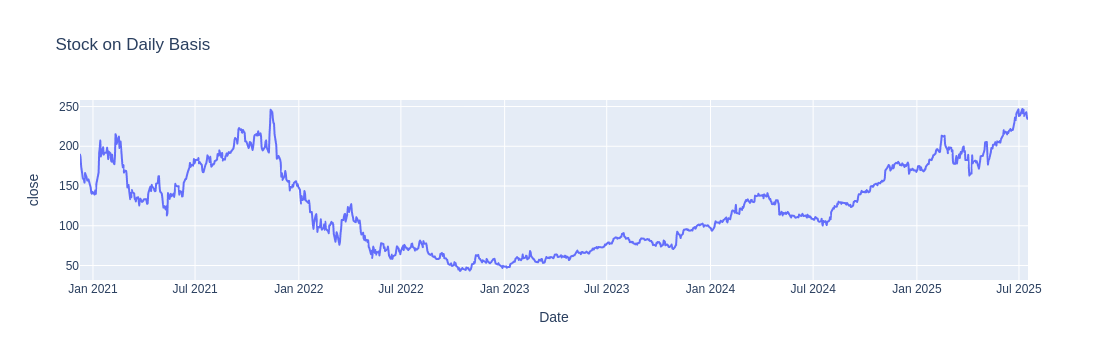

In [25]:
fig = px.line(df_stock, x="date", y="close", title="Stock on Daily Basis", 
              labels={"date": "Date"})

fig.show()

### Adjust stock splits

In [16]:
# Some initial values
try:
    divisor = input("Divisor: ")
    divisor = int(divisor)
except ValueError:
    divisor = float(divisor)
    
split_date = input("Split Date (yyyy-mm-dd): ")
sql_query = """UPDATE stock_price SET `open`=`open`/{divisor}, high=`high`/{divisor}, low=`low`/{divisor}, `close`=`close`/{divisor}
where `date` < '{split_date}' and symbol='{symbol}';""".format(divisor=divisor, split_date=split_date, symbol=symbol)
affected_rows = 0

# Make the update
truncate_bool = input("Truncate the database? (y/n): ")
if truncate_bool in ("y", "Y"):
    affected_rows = loader.query(sql_query)
    
print("Affected Rows in database:", affected_rows)
print("Sql Query:", sql_query)

Divisor:  0.16666
Split Date (yyyy-mm-dd):  2003-06-16
Truncate the database? (y/n):  y


Affected Rows in database: 908
Sql Query: UPDATE stock_price SET `open`=`open`/0.16666, high=`high`/0.16666, low=`low`/0.16666, `close`=`close`/0.16666
where `date` < '2003-06-16' and symbol='BKNG';


### The Volatility for the cut off the timeframe 

In [26]:
# Volatility Calculation
df_stock['volatility_max'] = (df_stock['high'] - df_stock['low']).rolling(21).max()
df_stock['volatility_mean'] = (df_stock['high'] - df_stock['low']).rolling(21).mean()

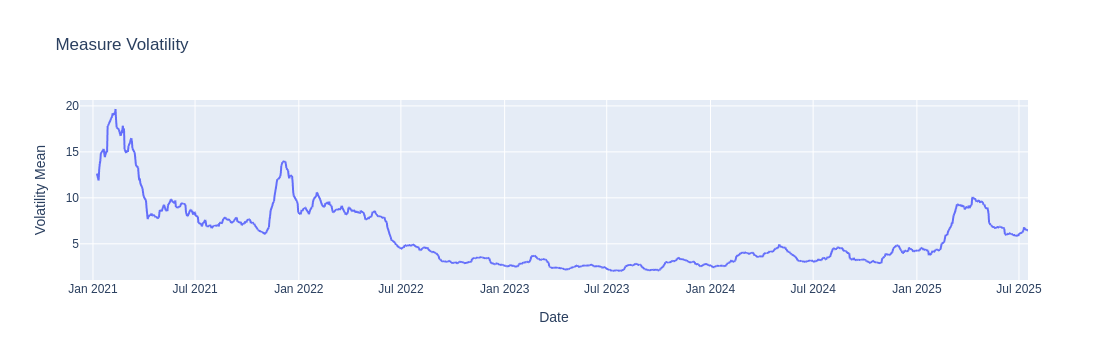

In [27]:
# Show it
fig = px.line(df_stock, x="date", y="volatility_mean", title="Measure Volatility", 
              labels={"date": "Date", "volatility_mean": "Volatility Mean"})
fig.show()

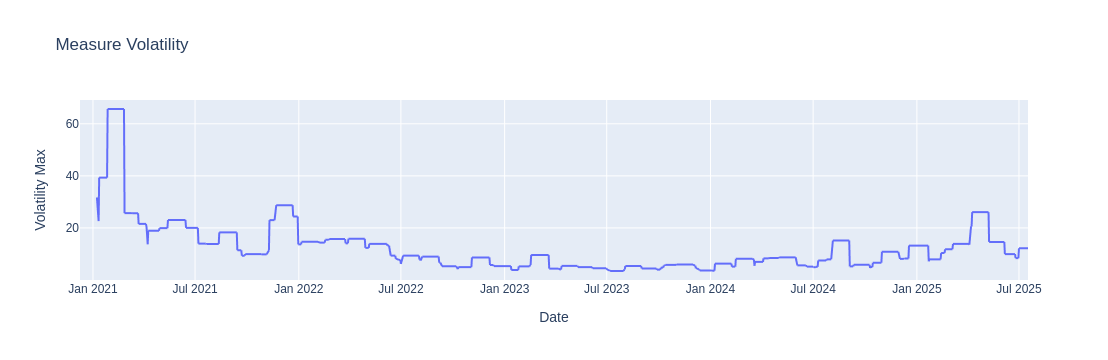

In [28]:
# Show it
fig = px.line(df_stock, x="date", y="volatility_max", title="Measure Volatility", 
              labels={"date": "Date", "volatility_max": "Volatility Max"})
fig.show()

### Truncate the timeframe

In [29]:
# Select the timestamp
symbol = df_stock.loc[0, "symbol"]
affected_rows = 0

# Truncate the dataframe
df_stock = df_stock[df_stock['date'] >= time_stamp]

# Update the database or not
truncate_date = input("Truncate Date (yyyy-mm-dd): ")
delete_string = f"DELETE FROM stock_price WHERE symbol='{symbol}' AND `date`<'{truncate_date}';"
truncate_bool = input("Truncate the database? (y/n): ")

if truncate_bool in ("y", "Y"):
    affected_rows = loader.query(delete_string)
    
    # Truncate the pandas dataframe
    df_stock = df_stock[df_stock['date'] >= truncate_date]

    
print(df_stock.head())
print(df_stock.tail())
print("Affected Rows in database:", affected_rows)

# Hier stehen geblieben

Truncate Date (yyyy-mm-dd):  2022-07-01
Truncate the database? (y/n):  y


    symbol       date   open    high    low  close  volatility_max  \
392   DASH 2022-07-01  65.05  69.330  65.05  67.95            6.19   
393   DASH 2022-07-05  66.22  75.060  65.69  74.90            9.37   
394   DASH 2022-07-06  67.79  70.000  66.84  69.36            9.37   
395   DASH 2022-07-07  69.33  76.000  68.18  76.00            9.37   
396   DASH 2022-07-08  74.20  77.415  72.56  74.96            9.37   

     volatility_mean  
392         4.433905  
393         4.625810  
394         4.563667  
395         4.753905  
396         4.865810  
     symbol       date    open     high     low   close  volatility_max  \
1150   DASH 2025-07-11  238.29  241.960  237.00  240.44            12.2   
1151   DASH 2025-07-14  240.15  243.600  238.79  242.85            12.2   
1152   DASH 2025-07-15  239.39  239.570  234.60  236.77            12.2   
1153   DASH 2025-07-16  236.94  237.845  233.92  234.50            12.2   
1154   DASH 2025-07-17  235.45  236.055  232.10  235.02           